Preparation

In [35]:
# import the libraries we need for this lab

# allows us to use arrays to manipulate and store data
import numpy as np
# PyTorch Library
import torch
# PyTorch Neural Network
import torch.nn as nn
# allows us to use activation functions
import torch.nn.functional as F
# used to graph data and loss curves
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap
# used to help create the dataset and perform mini-batch
from torch.utils.data import Dataset, DataLoader

In [36]:
# Plot the data

def plot_decision_regions_2class(model,data_set):
  cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])
  cmap_bold = ListedColormap(['#FF0000', '#00FF00','#00AAFF'])
  X = data_set.x.numpy()
  y = data_set.y.numpy()
  h = .02
  x_min, x_max = X[:, 0].min() -0.1, X[:,0].max() + 0.1
  y_min, y_max = X[:, 0].min() -0.1, X[:,0].max() + 0.1
  xx, yy = np.meshgrid(np.arange(x_min, x_max,h), np.arange(y_min,y_max,h))
  XX = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])

  yhat = np.logical_not((model(XX)[:,0]>0.5).numpy()).reshape(xx.shape)
  plt.pcolormesh(xx,yy,yhat,cmap = cmap_light,shading = 'auto')
  plt.plot(X[y[:,0] == 0 , 0], X[y[:,0] == 0, 1], 'o', label = 'y=0')
  plt.plot(X[y[:,0] == 1 , 0], X[y[:,0] == 1, 1], 'ro', label = 'y=1')
  plt.title("decision region")
  plt.legend()

In [37]:
# Calculate the accuracy

def accuracy(model, data_set):
  # rounds prediction to nearest interger 0 or 1
  # checks if prediction matches the actual values and returns accuracy rate
  return np.mean(data_set.y.view(-1).numpy() == (model(data_set.x)[:,0] > 0.5).numpy())

Neutral Network Module and Training Function

define the neural network module or class:

In [38]:
from pyparsing.helpers import Forward
class Net(nn.Module):
  #constructor  
  def __init__(self, D_in, H, D_out):
    super(Net, self).__init__()
    # D_in is the input size of the first layer(size of input layer)
    # H is the output size of the first layer and the input size of second layer(size of hidden layer)
    # D_out is the output size of the second layer(size of output layer)
    self.linear1 = nn.Linear(D_in, H)
    self.linear2 = nn.Linear(H, D_out)

  #prediction
  def forward(self, x):
    #puts x through first layer then sigmoid function
    x = torch.sigmoid(self.linear1(x))
    #puts result of previous line through second layer then sigmoid funtion
    x = torch.sigmoid(self.linear2(x))
    #output is a number between 0 and 1 due to the sigmoid function. whichever the output is closer to, 0 or 1 is the class prediciton
    return x

define a function to train the model

In [39]:
def train(data_set, model, criterion, train_loader, optimizer, epochs=5):
  #lists to keep track of cost and accuracy
  COST = []
  ACC = []
  #number of times we train on the entire dataset
  for epoch in range(epochs):
    #total loss over epoch
    total=0
    #for batch in train loader
    for x,y in train_loader:
      optimizer.zero_grad()
      yhat=model(x)
      loss=criterion(yhat,y)
      loss.backward()
      optimizer.step()
      total+=loss.item()
    ACC.append(accuracy(model, data_set))
    COST.append(total)
  
  # prints Cost vs Epoch graph
  fig, ax1 = plt.subplots()
  color = "tab:red"
  ax1.plot(COST, color=color)
  ax1.set_xlabel('epoch', color=color)
  ax1.set_ylabel('total loss', color=color)
  ax1.tick_params(axis='y', color=color)

  #prints Accuracy vs Epoch graph
  ax2 = ax1.twinx()
  color='tab:blue'
  ax2.set_ylabel('accuracy', color=color)
  ax2.plot(ACC, color=color)
  ax2.tick_params(axis='y', color=color)
  fig.tight_layout()
  plt.show()
  return COST

Make some data

In [40]:
# define the class XOR_Data
class XOR_Data(Dataset):
  #Constructor
  #N_s is the size of the dataset
  def __init__(self, N_s=100):
    # create a N_s by 2 array for the X values representing the coordinates
    self.x = torch.zeros((N_s,2))
    # create a N_s by 1 array for the X values belongs to
    self.y = torch.zeros((N_s,1))
    #split the dataset into 4 sections
    for i in range(N_s//4):
      # create data centerd around (0,0) of class 0
      self.x[i,:]=torch.Tensor([0.0,0.0])
      self.y[i,0]=torch.Tensor([0.0])

      # create data centerd around (0,1) of class 1
      self.x[i+N_s//4,:]=torch.Tensor([0.0,1.0])
      self.y[i+N_s//4,0]=torch.Tensor([1.0])

      # create data centerd around (1,0) of class 1
      self.x[i+N_s//2,:]=torch.Tensor([1.0,0.0])
      self.y[i+N_s//2,0]=torch.Tensor([1.0])

      # create data centerd around (1,1) of class 0
      self.x[i+3*N_s//4,:]=torch.Tensor([1.0,1.0])
      self.y[i+3*N_s//4,0]=torch.Tensor([0.0])

      # add some noist to the X values to make them different
      self.x = self.x + 0.01*torch.randn((N_s, 2))
    self.len = N_s

  # Getter
  def __getitem__(self, index):
    return self.x[index],self.y[index]
  
  # Get length
  def __len__(self):
    return self.len
  
  # Plot the data
  def plot_stuff(self):
    plt.plot(self.x[self.y[:,0]==0,0].numpy(), self.x[self.y[:,0]==0,1].numpy(), 'o', label="y=0")
    plt.plot(self.x[self.y[:,0]==1,0].numpy(), self.x[self.y[:,0]==1,1].numpy(), 'ro', label="y=1")
    plt.legend()


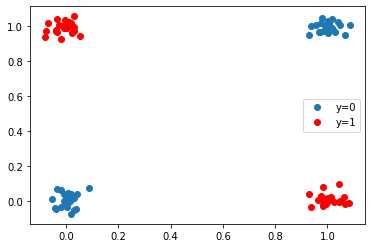

In [41]:
#Create dataset object 
data_set = XOR_Data()
data_set.plot_stuff()

One neuron

In [42]:
model = Net(D_in = 2, H = 1, D_out = 1)

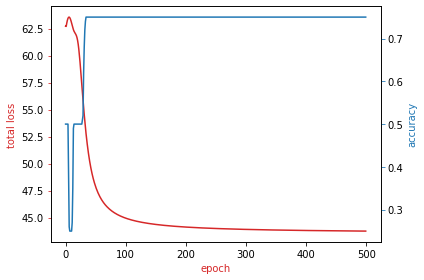

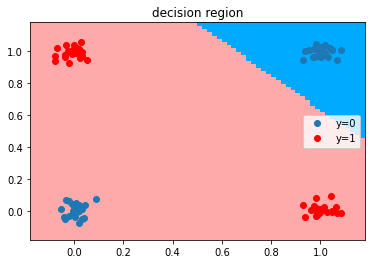

In [43]:
learning_rate = 0.1
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = DataLoader(dataset=data_set, batch_size = 1)
LOSS12 = train(data_set,model, criterion, train_loader, optimizer, epochs = 500)
plot_decision_regions_2class(model,data_set)

Two neurons

Two neurons

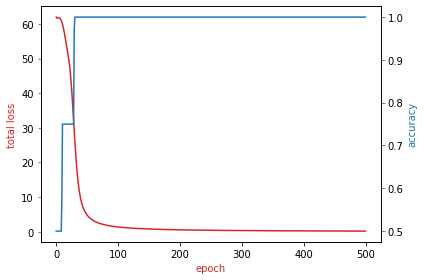

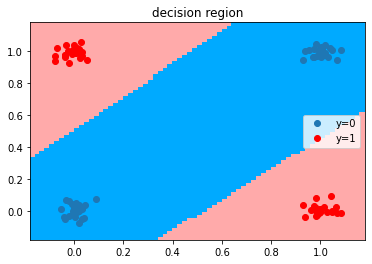

In [44]:
model = Net(D_in = 2, H = 2, D_out = 1)

learning_rate = 0.1
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = DataLoader(dataset=data_set, batch_size = 1)
LOSS12 = train(data_set,model, criterion, train_loader, optimizer, epochs = 500)
plot_decision_regions_2class(model,data_set)


Three neurons

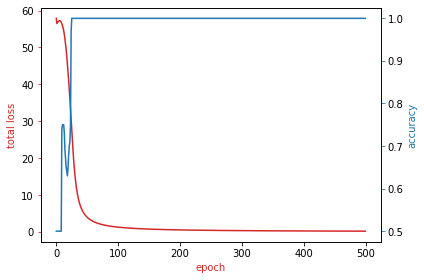

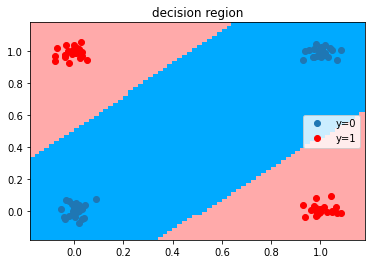

In [45]:
model = Net(D_in = 2, H = 3, D_out = 1)

learning_rate = 0.1
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = DataLoader(dataset=data_set, batch_size = 1)
LOSS12 = train(data_set,model, criterion, train_loader, optimizer, epochs = 500)
plot_decision_regions_2class(model,data_set)